# Setting boundary conditions in PorePy
Before reading this tutorial, we recommend reading [the single phase flow tutorial](./single_phase_flow.ipynb).

In this tutorial we will visit how to set boundary conditions for different model problems in PorePy.

We start by defining the geometry for the example models that we will show below:

In [1]:
from porepy.applications.md_grids.domains import nd_cube_domain
import numpy as np
import porepy as pp


class ModifiedGeometry:
    def set_domain(self) -> None:
        """Defining a two-dimensional square domain with sidelength 2."""
        size = self.solid.convert_units(2, "m")
        self._domain = nd_cube_domain(2, size)

    def grid_type(self) -> str:
        """Choosing the grid type for our domain."""
        return self.params.get("grid_type", "cartesian")

    def meshing_arguments(self) -> dict:
        """Meshing arguments for md-grid creation."""
        cell_size = self.solid.convert_units(0.25, "m")
        mesh_args: dict[str, float] = {"cell_size": cell_size}
        return mesh_args

# Basics
PorePy provides several ways to tailor the boundary conditions for your problem.
To set a boundary condition do the following:

1) Specify the type of the boundary condition (Dirichlet or Neumann) in the method named `bc_type_<flux_name>`.

2) Set the values of relevant physical quantities on the boundary in the method named `bc_values_<physical_quantity>`.

All methods for setting boundary conditions follow the naming convention listed above. 

Some of the possible physical quantities will be listed below in this tutorial. All the possible methods can be found in the source code of the `BoundaryConditionMixin` of the corresponding model, for example:

In [2]:
for x in dir(pp.models.fluid_mass_balance.BoundaryConditionsSinglePhaseFlow):
    if x.startswith("bc_values") or x.startswith("bc_type"):
        print(x)

bc_type_darcy_flux
bc_type_fluid_flux
bc_values_darcy_flux
bc_values_fluid_flux
bc_values_pressure


Let us consider the basic example of setting these boundary conditions for the single-phase flow model:

* West boundary: constant Neumann in-flux in the middle of the side, no flux elsewhere.
* East boundary: constant non-zero Dirichlet pressure.
* South and north boundaries: no flux.

The type of a boundary condition is set with the `pp.BoundaryCondition` class. By default, it sets all the boundary faces to Neumann. To set Dirichlet conditions, the relevant boundary sides should be provided to `pp.BoundaryCondition`. 
The domain sides are accessed with the `domain_boundary_sides` method.

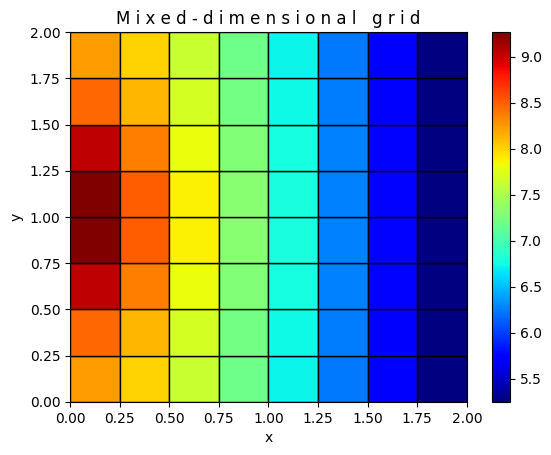

In [4]:
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class SinglePhaseFlowExample1(ModifiedGeometry, SinglePhaseFlow):
    def bc_type_fluid_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Setting the Dirichlet type on the east boundary, Neumann elsewhere."""
        domain_sides = self.domain_boundary_sides(sd)
        return pp.BoundaryCondition(sd, faces=domain_sides.east, cond="dir")

    def bc_values_fluid_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Setting the values of the fluid mass flux."""
        mass_flux_vals = np.zeros(boundary_grid.num_cells)

        domain_sides = self.domain_boundary_sides(boundary_grid)
        influx_cells = np.zeros(boundary_grid.num_cells, dtype=bool)
        influx_cells[domain_sides.west] = True
        # Setting the values on the west boundary where 0.5 < y < 1.5
        # "&" operator is the elementwise boolean AND
        influx_cells &= boundary_grid.cell_centers[1] > 0.5
        influx_cells &= boundary_grid.cell_centers[1] < 1.5

        mass_flux_vals[influx_cells] = self.fluid.convert_units(-1, "kg*s^-1")
        return mass_flux_vals

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        pressure_vals = np.zeros(boundary_grid.num_cells)
        domain_sides = self.domain_boundary_sides(boundary_grid)
        pressure_vals[domain_sides.east] = self.fluid.convert_units(5, "Pa")
        return pressure_vals

model_params = {}
single_phase_flow = SinglePhaseFlowExample1(params=model_params)
pp.run_time_dependent_model(single_phase_flow)
pp.plot_grid(single_phase_flow.mdg, single_phase_flow.pressure_variable, plot_2d=True)

The Dirichlet pressure values of 5 Pa on the east boundary affect the pressure in the whole system, and we observe a pressure drop from the west to the east which corresponds to the flux from the west boundary.

# Single-phase fluid
We revisit here all the methods to set boundary conditions for the single phase fluid model.

Consider the mass balance equation with zero source term:
$\phi \dfrac{\partial \rho}{\partial t} + \nabla \cdot F = 0$, where $\phi \frac{\partial \rho}{\partial t}$ is the accumulation term, and $F$ is the fluid mass flux that flows in a cell.

There are three ways of how to set boundary conditions for this model. The flowchart below outlines the order of evaluation of the boundary conditions operators. Use it and refer to the specific case below:

<img src='img/single_phase_flow_bc.jpg' width=600>

## 1. Setting the fluid mass flux
We can directly set the values of $F$ on a boundary by:
* marking the boundary faces as `neu` in the `bc_type_fluid_flux` method
* providing the values of $F$ in `bc_values_fluid_flux`

Note that we provide only the normal component of $F$. If cells are marked as `dir` in `bc_type_fluid_flux`, the values of $F$ are computed based on the other types of boundary conditions.

We used this type of boundary condition on all but the east boundary in the example above.

Pro tip: the no-flux boundary condition can be applied by setting the zero values here.

## 2. Setting the Darcy flux
The expression for $F$ is the following: $F = -\dfrac{\rho}{\mu}K \nabla p$, where $\dfrac{\rho}{\mu}$ is the advected quantity and $-K \nabla p$ is the Darcy flux.

In realistic setups, the values of $\rho$ and $\mu$ can depend on primary variables. For example, $\rho = \rho(p, T)$ and $\mu = \mu(T)$ in case of the non-isothermal fluid. 
It may be convenient to set the boundary condition in terms of the Darcy flux. 
The boundary values for the advected quantity will be computed automatically using the same constitutive laws as in the interior. 
This helps prevent inconsistencies between expressions used to calculate these quantities on the boundary versus within the domain, which can cause notorious bugs. 
The Darcy flux boundary condition is applied by:
* ensuring that we do not use the boundary values for $F$ by checking that `bc_type_fluid_flux == dir` for our boundary faces
* setting the boundary faces as `neu` in `bc_type_darcy_flux`
* setting the values of primary variables that are used to evaluate $\rho$ and $\mu$ on the boundary in `bc_values_pressure` and the other methods corresponding to each variable in use
* setting the values for the Darcy flux in `bc_values_darcy_flux`

We will set this boundary condition at the west side of the domain in the example below.

## 3. Setting pressure Dirichlet values
Finally, the Darcy flux can be evaluated by the provided pressure values. This is done by:
* ensuring that we do not use the boundary values for $F$ by checking that `bc_type_fluid_flux == dir` for our boundary faces
* setting the boundary faces as `dir` in `bc_type_darcy_flux`
* setting pressure values on the boundary in `bc_values_pressure`

We used this type of boundary condition on the east boundary in the example above.



Now, we will run the model with a Darcy flux boundary condition. The setup will use the same values for the boundary conditions as in the example above. To demonstrate the advantage of the Darcy flux boundary condition, we will increase the fluid viscosity $\mu$ by 10 times and see what will happen: 

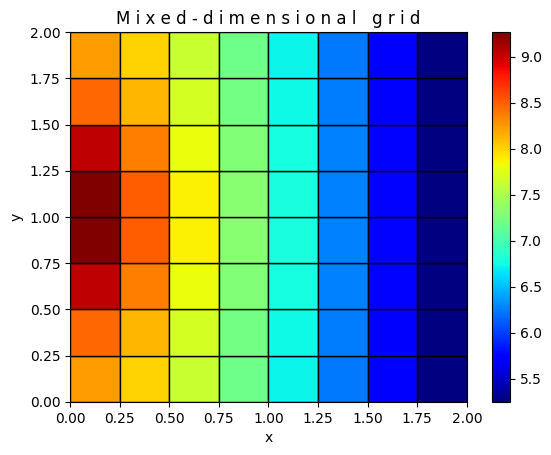

In [9]:
import numpy as np
import porepy as pp
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class SinglePhaseFlowExample2(ModifiedGeometry, SinglePhaseFlow):
    # Note that now this is bc_type_darcy_flux, not the bc_type_fluid_flux.
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Everything is the same as in the previous example."""
        domain_sides = self.domain_boundary_sides(sd)
        return pp.BoundaryCondition(sd, faces=domain_sides.east, cond="dir")

    # Note that now this is bc_values_darcy_flux, not the bc_values_fluid_flux.
    def bc_values_darcy_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Setting the Darcy flux values on the west boundary."""
        darcy_flux_vals = np.zeros(boundary_grid.num_cells)

        # Same as in the previous example
        domain_sides = self.domain_boundary_sides(boundary_grid)
        influx_cells = np.zeros(boundary_grid.num_cells, dtype=bool)
        influx_cells[domain_sides.west] = True
        influx_cells &= boundary_grid.cell_centers[1] > 0.5
        influx_cells &= boundary_grid.cell_centers[1] < 1.5

        # The value is the same
        darcy_flux_vals[influx_cells] = self.fluid.convert_units(-1, "Pa*m^-1")
        return darcy_flux_vals

    # This method did not change.
    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Everything is the same as in the previous example."""
        pressure_vals = np.zeros(boundary_grid.num_cells)
        domain_sides = self.domain_boundary_sides(boundary_grid)
        pressure_vals[domain_sides.east] = self.fluid.convert_units(5, "Pa")
        return pressure_vals

# We modify the fluid viscosity.
fluid_constants = pp.FluidConstants(
    {
        "viscosity": 10,  # 10 times larger than in the previous example.
    }
)
model_params = {
    "material_constants": {"fluid": fluid_constants}
}
single_phase_flow = SinglePhaseFlowExample2(
    params=model_params
)
pp.run_time_dependent_model(single_phase_flow)
pp.plot_grid(single_phase_flow.mdg, single_phase_flow.pressure_variable, plot_2d=True)

The flux did not change, which is the expected behavior. The Darcy flux BC automatically applies the correct values of the convected quantity (it includes $\mu$) to the boundary. However, if we used the `fluid_flux_bc_values` and changed $\mu$, the flux would also change, as it knows nothing about the convected quantity! It could potentially lead to an error if we computed the flux manually based on the old value of $\mu$, and then forgot to recompute it.

Excercise: Apply the different $\mu$ to the first example and see how the fluid flux changes.

# Momentum balance
Similar to the previous problems, we need to define one method for the type of boundary condition we are interested in, and another one for assigning the values. 
The momentum balance model class has the following methods predefined for setting boundary condition types and values:
* `bc_type_mechanics` for setting boundary condition type.
* `bc_values_displacement` for Dirichlet values.
* `bc_values_stress` for Neumann values.

As opposed to with the previous examples, this is a vector problem. 
Therefore we have to assign vectorial boundary condition values. 
In addition to this we will demonstrate how to set time-dependent boundary condition values. 
This is shown below:


In [10]:
import numpy as np
import porepy as pp

from porepy.models.momentum_balance import MomentumBalance


class ModifiedBoundaryConditions:
    def bc_type_mechanics(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        """Set boundary condition type for the problem."""
        bounds = self.domain_boundary_sides(sd)

        # Set the type of west and east boundaries to Dirichlet. North and south are
        # Neumann by default.
        bc = pp.BoundaryConditionVectorial(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_stress(self, bg: pp.BoundaryGrid) -> np.ndarray:
        """Setting stress boundary condition values at north and south boundaries.

        Specifically, we assign different values for the x- and y-component of the
        boundary value vector.

        """
        values = np.ones((self.nd, bg.num_cells))
        bounds = self.domain_boundary_sides(bg)

        # Assigning x-component values
        values[0][bounds.north + bounds.south] *= self.solid.convert_units(4.5, "Pa")

        # Assigning y-component values
        values[1][bounds.north + bounds.south] *= self.solid.convert_units(0.5, "Pa")

        return values.ravel("F")

    def bc_values_displacement(self, bg: pp.BoundaryGrid) -> np.ndarray:
        """Setting displacement boundary condition values.

        This method returns an array of boundary condition values with the value 5t for
        western boundaries and ones for the eastern boundary.

        """
        # Fetch the time of the current time-step
        t = self.time_manager.time

        values = np.zeros((self.nd, bg.num_cells))
        bounds = self.domain_boundary_sides(bg)

        # Assign a time dependent value to the x-component of the western boundary
        values[0][bounds.west] += self.solid.convert_units(5.0 * t, "m")
        values[0][bounds.east] += self.solid.convert_units(1.0, "m")

        # The convention for flattening nd-arrays of vector values in PorePy is by using
        # the Fortran-style ordering (chosen by string "F" when giving a call to ravel).
        # That is, the first index changes the fastest and the last index changes
        # slowest.
        return values.ravel("F")


class MomentumBalanceTimeDependentBC(
    ModifiedGeometry, ModifiedBoundaryConditions, MomentumBalance
):
    ...


# Set final time, amount of time-steps and the time-step size
final_time = 10.0
time_steps = 10.0
dt = final_time / time_steps

# Instantiate pp.TimeManager with the information provided above
time_manager = pp.TimeManager(
    schedule=[0.0, final_time],
    dt_init=dt,
    constant_dt=True,
)

# Include the time_manager to the model params dictionary
model_params = {
    "time_manager": time_manager
}
model = MomentumBalanceTimeDependentBC(model_params)
pp.run_time_dependent_model(model=model)

Visualization of the solution to this problem is demonstrated in the GIF below. 
We have used ParaView for the visualization and exaggerated the displacements for visualization purposes.

<img src='img/time_dependent_bc.gif'  width=600>

# What we have explored
We have seen how to set boundary conditions for both scalar and vector problems.
The examples presented in this tutorial are the physical problems of single phase flow and the momentum balance equation.